In [1]:
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime
from pathlib import Path
import os
import pandas as pd
import numpy as np


URL = 'https://www.olx.uz/oz/nedvizhimost/kvartiry/arenda-dolgosrochnaya/?currency=UZS'

today = datetime.today().strftime('%Y_%m_%d')
data_dir = Path('.').resolve().parent.parent / 'data/raw' / today

for folder in ('html', 'csv'):
    (data_dir / folder).mkdir(exist_ok=True)

In [2]:
def get_url(url: str, page: int, retry: int = 0):
    try:
        res = requests.get(url)
        with open(os.path.join(data_dir / 'html', f'houses_{page}.html'), 'wb') as f:
            f.write(res.content)
            
        return res.content
    except Exception:
        time.sleep(5)
        retry += 1
        print('Retrying the url:', url)
        if retry > 5:
            raise
        return get_url(url, retry)

In [3]:
def get_res_content(page):
    try:
        with open(os.path.join(data_dir / 'html', f'houses_{page}.html'), 'rb') as f:
            return f.read()
    except FileNotFoundError:
        url = f'{URL}&page={page}'
        return get_url(url, page)

In [4]:
page1 = get_res_content(page=1)
page1_soup = BeautifulSoup(page1)
list_items = page1_soup.select('li[data-testid=pagination-list-item]')
last_page = int(list_items[-1].select_one('a').text)
last_page

25

In [5]:
pages = range(1, last_page+1)

for page in pages:
    print('Downloading page:', page)
    get_res_content(page=page)

In [6]:
class Advertisement:
    BASE_URL = 'https://www.olx.uz'

    def __init__(self, url: str, ad_title: str, ad_price: str):
        self.url = url
        self.ad_title = ad_title
        self.ad_price = ad_price

    def get_data(self):
        url = self.BASE_URL + self.url
        res = requests.get(url) # TODO: Must handle connection errors
        soup = BeautifulSoup(res.content)
        all_columns = soup.select('div[data-testid=main] ul li p')
        ad_type, *all_columns = [col.text for col in all_columns]
        all_columns = [col.split(': ') for col in all_columns]
        ad_description = soup.select_one('div[data-testid=ad_description]').text
        arr1 = np.array([
            ['url', url],
            ['ad_title', self.ad_title],
            ['ad_price', self.ad_price],
            ['ad_type', ad_type]
        ])
        arr2 = np.array(all_columns)
        arr3 = np.array([ 
            ['ad_description', ad_description]
        ])
        data = np.concat([
            arr1, arr2, arr3   
        ], axis=0).T
        df = pd.DataFrame(data=data[1:], columns=data[0])
        return df

    def __str__(self):
        return f'Advertisement(url={self.url!r})'

    def __repr__(self):
        return f'Advertisement(url={self.url!r})'


In [7]:
def download_data(page: int):
    print('Downloading for page', page)
    content = get_res_content(page=page)
    soup = BeautifulSoup(content)

    cards = soup.select('div[data-testid=listing-grid] > div[data-cy=l-card] div[data-cy=ad-card-title]')

    advertisements = []
    for card in cards:
        title = card.select_one('a').text
        price = card.select_one('p').text
        url = card.select_one('a').attrs['href']
        ad = Advertisement(url, title, price)
        advertisements.append(ad)

    dfs = []
    for ad in advertisements:
        # print(ad.url)
        try:
            df = ad.get_data()
            dfs.append(df)
        except Exception:
            print('ERROR: ', ad.url)

    final_df = pd.concat(dfs)
    final_df.to_csv(data_dir / f'csv/houses_{page}.csv', index=False)
    

In [8]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as exe:
    exe.map(download_data, list(pages)[2:])

ERROR:  /d/oz/obyavlenie/sdam-kvartiru-2x-komnatnuyu-v-rajone-melodiya-ID3QUMG.html
ERROR:  /d/oz/obyavlenie/c1-da-3-xonali-kvartira-uzok-muddatga-izharaga-beriladi-ID3T1bD.html
ERROR:  /d/oz/obyavlenie/assalom-soxilda-joylashgan-3-xonali-kvartira-ijaraga-beriladi-ID3R6TO.html
ERROR:  /d/oz/obyavlenie/sdaetsya-v-arendu-novaya-2-x-komnatnaya-kvartiru-v-almazar-siti-ID3AWBm.html
 11
ERROR:  /d/oz/obyavlenie/arenda-kvartiry-ID3SZvd.html
ERROR:  /d/oz/obyavlenie/sergili-4-daha-5-metro-bekati-oldida-1-xona-2-xona-qilingan-uy-250-ga-ID3T195.html
ERROR:  /d/oz/obyavlenie/arenda-chilonzor-8kv-mirzo-ulugbek-metroga-yaqin-luks-kvartira-ID3T18C.html
ERROR:  /d/oz/obyavlenie/arenda-3x-kom-evro-kvartira-orientir-restoran-verona-ID3T0GN.html
ERROR:  /d/oz/obyavlenie/arenda-metro-chilanzar-nakoshlyk-24-3-4-razdelka-ID3RES1.html
ERROR:  /d/oz/obyavlenie/sdaetsya-kvartira-na-chilanzarskom-r-ne-novza-metro-ID3SQOj.html
ERROR:  /d/oz/obyavlenie/maksim-gorkiy-kvartira-ID3LqQG.html
ERROR:  /d/oz/obyavlenie

In [115]:
df1 = pd.read_csv(data_dir / f'csv/houses_{1}.csv')
df2 = pd.read_csv(data_dir / f'csv/houses_{2}.csv')
df = pd.concat([df1, df2])

In [14]:
from glob import glob

dfs = []
for file in glob(str(data_dir) + f'\\csv\\*.csv'):
    df = pd.read_csv(file)
    dfs.append(df)

final_df = pd.concat(dfs)

In [15]:
final_df.shape

(1271, 21)

In [50]:
final_df.drop_duplicates().shape

(1087, 21)

In [17]:
final_df.columns

Index(['url', 'ad_title', 'ad_price', 'ad_type', 'Xonalar soni',
       'Umumiy maydon', 'Qavati', 'Uy qavatliligi', 'Sanuzel', 'Mebelli',
       'Kvartirada bor', 'Yaqinida joylashgan', 'Vositachilik haqqi',
       'ad_description', 'Yashash maydoni', 'Oshxona maydoni', 'Qurilish turi',
       'Rejasi', 'Qurilgan yili', 'Shiftining balandligi', 'Taʼmiri'],
      dtype='object')

In [51]:
cols = ['ad_price', 'ad_type', 'Xonalar soni', 'Umumiy maydon', 'Qavati', 'Uy qavatliligi', 'Sanuzel', 'Mebelli',
    'Vositachilik haqqi', 'Yashash maydoni', 'Oshxona maydoni', 'Qurilish turi',
    'Rejasi', 'Qurilgan yili', 'Shiftining balandligi', 'Taʼmiri']

housing = final_df[cols].drop_duplicates()

In [52]:
housing.head()

,ad_price,ad_type,Xonalar soni,Umumiy maydon,Qavati,Uy qavatliligi,Sanuzel,Mebelli,Vositachilik haqqi,Yashash maydoni,Oshxona maydoni,Qurilish turi,Rejasi,Qurilgan yili,Shiftining balandligi,Taʼmiri
0,7 704 300 so’m,Jismoniy shaxs,3,68,4,9,Aralash,Ha,Yo’q,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,350 000 so’mKelishilgan\n,Jismoniy shaxs,3,150,2,4,Alohida,Ha,Yo’q,120 m²,25 m²,Gʻishtli,Alohida ajratilgan,2017,4.0,Evrotaʼmir
2,4 494 175 so’m,Jismoniy shaxs,2,52,1,4,Alohida,Ha,Yo’q,48 m²,NaN,Gʻishtli,Alohida ajratilgan,2011 - 2014,3.2,Evrotaʼmir
3,6 407 410 so’mKelishilgan\n,Biznes,2,63,3,9,Alohida,Ha,Bor,NaN,NaN,Gʻishtli,Alohida ajratilgan,NaN,3.0,Evrotaʼmir
4,4 494 175 so’m,Biznes,2,60,2,7,Alohida,Yoʻq,Yo’q,45 m²,NaN,Gʻishtli,Alohida ajratilgan,2016,NaN,Evrotaʼmir


In [53]:
housing['Sanuzel'].value_counts()

Sanuzel
Alohida                    493
Aralash                    273
2 va undan koʻp sanuzel     93
Name: count, dtype: int64

In [54]:
housing['Mebelli'].value_counts()

Mebelli
Ha      1024
Yoʻq      57
Name: count, dtype: int64

In [55]:
housing['Vositachilik haqqi'].value_counts()

Vositachilik haqqi
Bor     870
Yo’q    211
Name: count, dtype: int64

In [56]:
housing['Qurilish turi'].value_counts()

Qurilish turi
Gʻishtli     645
Panelli      123
Monolitli     74
Blokli         6
Yogʻoch        1
Name: count, dtype: int64

In [57]:
housing['Rejasi'].value_counts()

Rejasi
Alohida ajratilgan      625
Aralash-alohida          67
Aralash                  53
Studiya                  30
Koʻp darajali             4
Kichik oilalar uchun      2
Pentxaus                  1
Name: count, dtype: int64

In [58]:
housing['Taʼmiri'].value_counts()

Taʼmiri
Evrotaʼmir                    633
Mualliflik loyihasi           213
Oʻrtacha                      105
Qora suvoq                      1
Tozalashdan avvalgi pardoz      1
Name: count, dtype: int64

In [59]:
price = housing['ad_price'].replace({
    " so’m": "",
    "Kelishilgan\n": "",
    " ": ""
}, regex=True).astype(int)

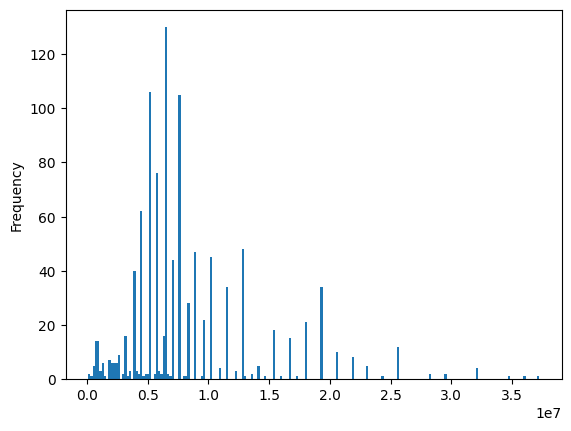

In [60]:
from matplotlib import pyplot as plt
price.plot.hist(bins=200)
plt.show()

In [64]:
price.value_counts().sort_index()

ad_price
100000      1
150000      1
350000      1
500000      1
550000      1
           ..
29533150    2
32101250    4
34669350    1
35953400    1
37237450    1
Name: count, Length: 104, dtype: int64

In [67]:
final_df.sort_values(by='ad_price')

,url,ad_title,ad_price,ad_type,Xonalar soni,Umumiy maydon,Qavati,Uy qavatliligi,Sanuzel,Mebelli,...,Yaqinida joylashgan,Vositachilik haqqi,ad_description,Yashash maydoni,Oshxona maydoni,Qurilish turi,Rejasi,Qurilgan yili,Shiftining balandligi,Taʼmiri
0,https://www.olx.uz/d/oz/obyavlenie/kvartira-ar...,Квартира аренда kvartira arenda,1 000 000 so’m,Jismoniy shaxs,2,40.98,5,5,Aralash,Yoʻq,...,"Supermarket, doʻkonlar, Bolalar bogʻchasi, Bek...",Yo’q,TavsifСирдарё вилоятм Янгиер шаҳри Ховос сити ...,23.72 m²,4 m²,Gʻishtli,Aralash-alohida,NaN,2.7,Mualliflik loyihasi
44,https://www.olx.uz/d/oz/obyavlenie/ijaraga-xon...,Ijaraga xona 1ta qiz uchun yunsabod tumani 16kv,1 000 000 so’mKelishilgan\n,Jismoniy shaxs,1,98,8,9,Alohida,Ha,...,"Kasalxona, poliklinika, Maktab, Bolalar maydon...",Yo’q,TavsifQizlar uchun ijaraga xona bor toza akura...,20 m²,NaN,Gʻishtli,Alohida ajratilgan,1990 - 2000,270.0,Oʻrtacha
46,https://www.olx.uz/d/oz/obyavlenie/sirochna-sh...,Sirochna sheriklikka kivartira bor,1 010 000 so’mKelishilgan\n,Jismoniy shaxs,2,95,2,9,Alohida,Ha,...,"Bolalar maydonchasi, Maktab, Koʻngilochar muas...",Yo’q,TavsifIjara kimga:qizlarga\nManzil:China house...,85 m²,46 m²,Gʻishtli,Aralash,2017,56.0,Evrotaʼmir
39,https://www.olx.uz/d/oz/obyavlenie/sheriklikka...,Шерикликка квартира угил болларга ишлидиган ук...,1 027 240 so’m,Jismoniy shaxs,3,68,4,7,Alohida,Ha,...,"Bolalar maydonchasi, Kasalxona, poliklinika, R...",Yo’q,TavsifСергели 4 бекатта шерикликка квартира уг...,56 m²,7 m²,Gʻishtli,Alohida ajratilgan,2016,NaN,Evrotaʼmir
40,https://www.olx.uz/d/oz/obyavlenie/sheriklikka...,Шерикликка квартира угил болларга ишлидиган ук...,1 027 240 so’m,Jismoniy shaxs,3,68,4,7,Alohida,Ha,...,"Bolalar maydonchasi, Kasalxona, poliklinika, R...",Yo’q,TavsifСергели 4 бекатта шерикликка квартира уг...,56 m²,7 m²,Gʻishtli,Alohida ajratilgan,2016,NaN,Evrotaʼmir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,https://www.olx.uz/d/oz/obyavlenie/arenda-kvar...,Аренда квартир для студентов,900 000 so’m,Jismoniy shaxs,5,100.0,2,2,2 va undan koʻp sanuzel,Ha,...,"Supermarket, doʻkonlar, Bolalar bogʻchasi, Bek...",Yo’q,TavsifСдается квартира в аренду для студентов ...,100 m²,100 m²,Gʻishtli,Aralash-alohida,2017,100.0,Mualliflik loyihasi
26,https://www.olx.uz/d/oz/obyavlenie/srochno-sda...,Срочно сдаются квартиры 2 ком Сергели 3 бекат ...,900 000 so’m,Biznes,2,75,3,8,Alohida,Ha,...,NaN,Yo’q,TavsifСдаётся квартира двухкомнатная все услуг...,35 m²,20 m²,Gʻishtli,Alohida ajratilgan,2017,30.0,Evrotaʼmir
35,https://www.olx.uz/d/oz/obyavlenie/beruni-metr...,Беруни метро дан 20 минутли йул хозяйинли болл...,900 000 so’m,Jismoniy shaxs,14,80,1,1,NaN,Ha,...,NaN,Yo’q,TavsifХовли жой хонага 4 та дан олинади\nИжара...,900 m²,NaN,NaN,NaN,NaN,NaN,NaN
39,https://www.olx.uz/d/oz/obyavlenie/kvartira-v-...,Квартира в аренду,900 000 so’m,Jismoniy shaxs,2,42,7,9,Alohida,Ha,...,"Bolalar maydonchasi, Maktab, turargoh, Restora...",Yo’q,TavsifСдаю квартиру уютно удобно со всеми удоб...,42 m²,25 m²,Panelli,Alohida ajratilgan,NaN,3.0,Evrotaʼmir
